# Problem 4 - Trajectory Optimization for a planar arm

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [1]:
import numpy as np
from IPython.display import HTML, SVG, display
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys
import pydot

from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.systems.planar_scenegraph_visualizer import ConnectPlanarSceneGraphVisualizer
from pydrake.systems.primitives import LogVectorOutput, WrapToSystem
from pydrake.all import StartMeshcat, MeshcatVisualizer, MeshcatVisualizerParams

In [2]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


## Set up Ball Trajectory

The ball is in the air for 0.6992906373179558s


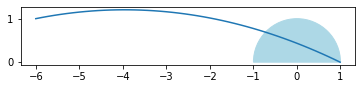

In [3]:
from matplotlib.patches import Wedge

g = 9.81

def CalcCatchPos(q0, v0, t_catch):
    y_final = q0[1] + v0[1] * t_catch
    x_final = q0[0] + v0[0] * t_catch
    z_final = q0[2] + v0[2] * t_catch - 0.5 * g * t_catch**2
    return np.array([x_final, y_final, z_final])

def tFall(q0, v0):
    # Solve 0 = q0[2] + v0[2] * t - 0.5 * g * t**2
    a = -0.5 * g
    b = v0[2]
    c = q0[2]
    return (-b - np.sqrt(b*b - 4*a*c)) / (2*a)

q0_ball = np.array([-6, 0, 1])
v0_ball = np.array([10, 1, 2])

max_t = tFall(q0_ball, v0_ball)
print(f'The ball is in the air for {max_t}s')
plot_t = np.linspace(0, max_t, 50)
plot_q = np.array([CalcCatchPos(q0_ball, v0_ball, t) for t in plot_t])

fig, ax = plt.subplots()
plt.gca().set_aspect('equal')
ax.plot(plot_q[:,0], plot_q[:,2])
# ax.add_patch(plt.Circle((0,0), 1, color='lightblue'))
ax.add_patch(Wedge((0,0), 1, 0, 180, color='lightblue'))
plt.show()

## Run trajectory optimization to find the optimal trajectory

In [7]:
import importlib
import catching_trajectory
importlib.reload(catching_trajectory)
import xmltodict

from catching_trajectory import find_throwing_trajectory

N = 30
# initial_state = [0.11779206, -0.5012354,  0.01978261, -2.7, 0.02984053, 0.02119353, 0] + [0] * 7
initial_state = [0.11779206, -0.1012354,  0.01978261, -0.5, 0.02984053, 0.02119353, 0] + [0] * 7

final_configuration = np.array([np.pi, 0])
tf = 1
distance = 15.0

# Create obstacle based on urdf
obs_params = np.empty((0, 4))
n_obs = 0
with open('obstacle.urdf', 'r', encoding='utf-8') as file: 
    obs_urdf = file.read() 
obs_dict = xmltodict.parse(obs_urdf)

for link in obs_dict["robot"]["link"]:
    obs_pos = link["visual"]["origin"]["@xyz"]
    obs_radius = link["visual"]["geometry"]["sphere"]["@radius"]
    obs_pos = np.array([float(o) for o in obs_pos.split(" ")])
    obs_radius = float(obs_radius)
    obs_params = np.vstack((obs_params, np.append(obs_radius,obs_pos)))
    n_obs += 1

# print("obs params = \n", obs_params)

x_traj, u_traj, t_catch, prog, _, _ = find_throwing_trajectory(N, q0_ball, v0_ball, initial_state, final_configuration, distance, obs_params)


n_q =  7
n_v =  7
n_x =  14
n_u =  7
[87. 87. 87. 87. 12. 12. 12.]
[2.175 2.175 2.175 2.175 2.61  2.61  2.61 ]
Solver is  SNOPT
optimal cost:  362712.24752621684
x_sol:  [[ 1.17792060e-01 -1.01235400e-01  1.97826100e-02 -5.00000000e-01
   2.98405300e-02  2.11935300e-02  5.58967981e-14 -1.19004923e-13
   6.82496615e-14 -1.94799863e-13  1.52758412e-13  3.13471663e-14
  -7.40072494e-14 -1.15354167e-13]
 [ 1.01113231e-01 -1.13588277e-01  4.07619276e-02 -5.22546008e-01
   1.81826174e-02  3.05334109e-02 -1.02577212e-02 -1.24833031e+00
  -1.14682522e+00  1.81084547e+00 -1.92421288e+00 -1.27642828e+00
   9.78516489e-01 -1.08989050e+00]
 [ 8.05824286e-02 -1.40663071e-01  7.87285507e-02 -5.61921007e-01
  -1.71992589e-02  5.75981907e-02 -4.10573897e-02 -9.84477900e-01
  -1.70090662e+00  2.17500000e+00 -2.17500000e+00 -2.38371136e+00
   1.89735380e+00 -2.18231592e+00]
 [ 6.97402918e-02 -1.76454996e-01  1.20331900e-01 -6.02876698e-01
  -6.61295827e-02  1.00605996e-01 -8.82487433e-02  1.31144462e-01

## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time

from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource,
    AddMultibodyPlantSceneGraph, ApplyVisualizationConfig, VisualizationConfig, MeshcatPointCloudVisualizer,
    PointCloud, Fields, BaseField, AbstractValue, InputPort_, SimulatorConfig, ApplySimulatorConfig
)

def create_ee_query():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
    # Parser(plant).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
    Parser(plant).AddModels("./panda_arm_custom.urdf")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
    plant.Finalize()
    context = plant.CreateDefaultContext()
    ee_frame = plant.GetBodyByName("panda_link9").body_frame()
    def query(state):
        context.SetContinuousState(state)
        return plant.CalcPointsPositions(context, ee_frame, np.zeros(3), plant.world_frame()).ravel()
    return query


def AddObstacleToPlant(builder, scene_graph):
  obstacle = builder.AddSystem(MultibodyPlant(0.0))
  obstacle.RegisterAsSourceForSceneGraph(scene_graph)
  builder.Connect(obstacle.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(obstacle.get_source_id()))
  builder.Connect(scene_graph.get_query_output_port(), obstacle.get_geometry_query_input_port())
  Parser(plant=obstacle).AddModels("./obstacle.urdf")
  obstacle.set_name("obstacle")

  for i in range(n_obs):
    obs_name = "obs_" + str(i)
    obstacle.WeldFrames(obstacle.world_frame(), obstacle.GetFrameByName(obs_name))
    
  obstacle.Finalize()

def AddPathBallToPlant(builder, scene_graph, x_traj):
  path_ball = builder.AddSystem(MultibodyPlant(0.0))
  path_ball.RegisterAsSourceForSceneGraph(scene_graph)
  builder.Connect(path_ball.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(path_ball.get_source_id()))
  builder.Connect(scene_graph.get_query_output_port(), path_ball.get_geometry_query_input_port())
  Parser(plant=path_ball).AddModels("./path.urdf")
  path_ball.set_name("path_ball")

  ee_traj = np.empty((0,3))
  t = 0
  while t <= t_catch:
      ee_traj = np.vstack((ee_traj, create_ee_query()(x_traj.value(t))))
      t += t_catch/N

  ee_traj_source = builder.AddSystem(TrajectorySource(ee_traj))

  demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
  to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(path_ball))

  builder.Connect(ee_traj_source.get_output_port(), demux.get_input_port())
  builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
  builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(path_ball.get_source_id()))
  builder.Connect(scene_graph.get_query_output_port(), path_ball.get_geometry_query_input_port())

  path_ball.Finalize()

# Create a MultibodyPlant for the arm
# file_name = "panda_arm.urdf"
builder = DiagramBuilder()
ball, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
# scene_graph = builder.AddSystem(SceneGraph())
panda_arm = builder.AddSystem(MultibodyPlant(0.0))
# panda_arm, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
panda_arm.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=panda_arm).AddModels("./panda_arm_custom.urdf")
# Parser(plant=panda_arm).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
panda_arm.WeldFrames(panda_arm.world_frame(), panda_arm.GetFrameByName("panda_link0"))
panda_arm.Finalize()

AddObstacleToPlant(builder, scene_graph)
# AddPathBallToPlant(builder, scene_graph, x_traj)

# ball = builder.AddSystem(MultibodyPlant(0.0))
Parser(plant=ball).AddModels("./ball.urdf")
# ball.WeldFrames(ball.world_frame(), ball.GetFrameByName("base"))

ball.Finalize()
# ball.RegisterAsSourceForSceneGraph(scene_graph)
# builder.Connect(ball.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(ball.get_source_id()))
# builder.Connect(scene_graph.get_query_output_port(), ball.get_geometry_query_input_port())

n_q = panda_arm.num_positions()
n_v = panda_arm.num_velocities()
n_u = panda_arm.num_actuators()

print("n_q = ", n_q)
print("n_v = ", n_v)
print("n_u = ", n_u)

x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(panda_arm))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), panda_arm.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(panda_arm.get_source_id()))
builder.Connect(scene_graph.get_query_output_port(), panda_arm.get_geometry_query_input_port())

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

visualization_config = VisualizationConfig()
visualization_config.publish_proximity = True
ApplyVisualizationConfig(visualization_config, builder, meshcat=meshcat)

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the motion for `n_playback` times
n_playback = 1
for i in range(n_playback):
  # Set up a simulator to run this diagram.
    context = diagram.CreateDefaultContext()
    ball.SetPositions(ball.GetMyContextFromRoot(context), [0, 0, 0, 1, *q0_ball])
    ball.SetVelocities(ball.GetMyContextFromRoot(context), [0, 0, 0, *v0_ball])
    simulator = Simulator(diagram, context)
    simulator_config = SimulatorConfig(max_step_size=1e-4, accuracy=1e-4, publish_every_time_step=True)
    ApplySimulatorConfig(simulator_config, simulator)
    simulator.Initialize()
    time.sleep(1)
    simulator.set_target_realtime_rate(0.1)
    simulator.AdvanceTo(t_catch)
    time.sleep(1)

n_q =  7
n_v =  7
n_u =  7
